# Music genre classifier
## Pretrained classifiers
This notebook should be see as the third step in a series of notebooks aimed to build an ML audio classifier.

We continue our journey of music classification now by comparing our results against a pretrained model. 
You can find the other notebooks for this experiment here:

- [data exploration](https://github.com/pmhalvor/music-genre-classifier/blob/main/notebooks/data_exploration.ipynb)
- [preprocessing](https://github.com/pmhalvor/music-genre-classifier/blob/main/src/preprocess.py)
- [traditional classifiers](https://github.com/pmhalvor/music-genre-classifier/blob/main/notebooks/classifiers.ipynb)
- [simple nn classifiers](https://github.com/pmhalvor/music-genre-classifier/blob/main/notebooks/nn_classifiers.ipynb)

## Goal
Test open-source pretrained models on music classifications of the GTZAN dataset, and compare the results to our own models.

## Classifier
A new pretrained model for music classification is the Music Audio Efficient Spectrogram Transformer (MAEST) model (Alonso 2023, [GitHub](https://github.com/palonso/MAEST/), [Whitepaper](https://arxiv.org/abs/2309.16418)).
This model is in the family of Transformer models based on [PASST](https://github.com/kkoutini/PaSST) and focused on music analysis applications.
It improves on traditional CNN models by using a self-attention mechanism to learn the relationships between different parts of the spectrogram.
It was trained on the Discogs20 dataset, "an in-house dataset with 3.3 M tracks mapped to the Discogs’ public metadata dump." 
The model is available in the [HuggingFace model hub](https://huggingface.co/mtg-upf/discogs-maest-30s-pw-73e-ts).
Here is a visualization of the model architecture:
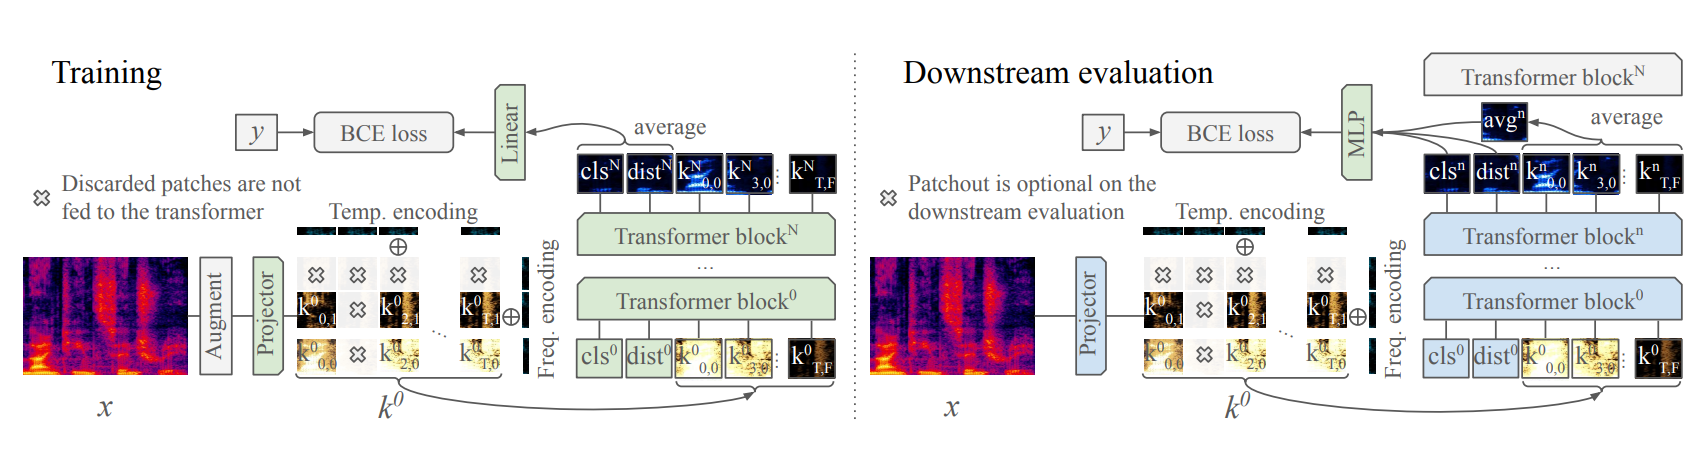

## Dataset
The dataset contains 1000 audio tracks each 30 seconds long. It contains 10 genres, each represented by 100 tracks. The tracks were all 22050Hz Mono 16-bit audio files in .wav format.
They are downloaded locally, with file paths stored in `data/file_paths.npy` (array for easier loading). 
Labels are similarly stored in `data/labels.npy`.

## Source
https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/ (accessed 2023-10-20)

In [1]:
import os # cd to root layer
os.chdir('/Users/per.morten.halvorsen@schibsted.com/personal/music-genre-classifiers')

In [2]:
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from tqdm import tqdm
from typing import Dict, Set

import datetime
import gc
import IPython.display as ipd
import numpy as np
import os
import plotly.express as px
import plotly.io as pio
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim

pio.renderers.default = 'notebook'

In [3]:
# load local data
file_paths = np.load("data/file_paths.npy")
labels = np.load("data/labels.npy")

print(file_paths[0])
print(labels[0])
ipd.Audio(file_paths[0])

../../data/gtzan_music_dataset/genres_original/pop/pop.00027.wav
pop


# Load MAEST as `ASTForAudioClassification`

In [4]:
k = {"trust_remote_code":True} # to avoid user input before loading model

if os.path.exists("models/discogs-maest-30s-pw-73e-ts"):
    feature_extractor = AutoFeatureExtractor.from_pretrained("models/discogs-maest-30s-pw-73e-ts", **k)
    model = ASTForAudioClassification.from_pretrained("models/discogs-maest-30s-pw-73e-ts", **k)

else:
    feature_extractor = AutoFeatureExtractor.from_pretrained("mtg-upf/discogs-maest-30s-pw-73e-ts", **k)
    model = ASTForAudioClassification.from_pretrained("mtg-upf/discogs-maest-30s-pw-73e-ts", **k)

    # save model so we don't have to download it each time
    model.save_pretrained("models/discogs-maest-30s-pw-73e-ts")
    feature_extractor.save_pretrained("models/discogs-maest-30s-pw-73e-ts")

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [5]:
MODEL_SAMPLING_RATE = 16000

wavform, sample_rate = torchaudio.load(file_paths[0])
print(wavform.shape)

resample = torchaudio.transforms.Resample(sample_rate, MODEL_SAMPLING_RATE)
rs_waveform = resample(wavform)
print(rs_waveform.shape)

# inputs = feature_extractor(resampled_wavform.squeeze(), return_tensors="pt")
inputs = feature_extractor(rs_waveform.squeeze(), sampling_rate=MODEL_SAMPLING_RATE,  return_tensors="pt")
inputs["input_values"].shape


torch.Size([1, 661504])
torch.Size([1, 480003])


torch.Size([1, 1876, 96])

The feature extractor converts the audio into spectrogram features, with 96 total coefficients for each of the 1876 sample windows.
This is much more detail than we previously used to train our other models, which only used 13 mfcc coefficients to represent each sample.
However, due to the architecture of the MAEST model, we need to keep this number of preprocessed features in order for the model's predictions to make any sense. 

Judging by the audio sample displayed in cell 3, we can can decide the MAEST label for this file would probably be "Pop---Vocal". 
We'll use this as our ground truth label, for out example input. Later, we'll look deeper into the labels in our datasets.  

In [6]:
target_label = "Pop---Vocal"

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_ids = torch.argmax(logits, dim=-1).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

# compute loss
inputs["labels"] = torch.tensor([model.config.label2id[target_label]])
loss = model(**inputs).loss
round(loss.item(), 2)

3.69

The dataflow worked fine here, and we were able to produce a loss for our example input.

Let's look a little more into the most confident outputs from our model to see if we agree with it's predicted labels and confidence scores for our example. We can do this using the `torch.top_k()` function.

In [7]:
top_k = torch.topk(logits.squeeze(0), k=10)
predictions = {
    model.config.id2label[index.item()]: torch.sigmoid(value).item()
    for index, value in zip(top_k.indices, top_k.values)
}
predictions

{'Pop---Europop': 0.31210359930992126,
 'Electronic---House': 0.27431821823120117,
 'Electronic---Euro House': 0.1644572615623474,
 'Electronic---Synth-pop': 0.1608554571866989,
 'Electronic---Downtempo': 0.14041538536548615,
 'Rock---Pop Rock': 0.13494785130023956,
 'Hip Hop---RnB/Swing': 0.11780744045972824,
 'Electronic---Trance': 0.1134004294872284,
 'Funk / Soul---Contemporary R&B': 0.09332862496376038,
 'Pop---Vocal': 0.0890185758471489}

In [8]:
ipd.Audio(file_paths[0])

Awesome!
While I personally wouldn't consider this sample to at all resemble house or trance music, the other labels seem pretty useful. 

Also, take note of the confidence scores. The model is not very confident in any of these predictions. 
This can be because the GTZAN samples look different from the samples the model was trained on (sample quality, sample length, songs used, etc).
However, the ranked predictions from this example would have been condisered correct in our simplfied classifier case (pop at the top). 
This seems promising going forward with our GTZAN dataset.

With this step complete, we consider the current model state to be good enough, for now.
The next step is to look into the scalability of our set-up.  

# Scaling up
We should extract features for our whole dataset, not just one example, and measure the time it takes.
This can be a potential bottleneck for our model, when preprocessing very large datasets. 

We also want to make sure the architecture of our model can be trained on batches. This will help in any evenutal fine-tuning we do later. 

In [9]:
# gtzan at 22050 but MAEST needs 16000
resample = torchaudio.transforms.Resample(22050, 16000)

wavforms = [
    resample(torchaudio.load(file_path)[0]).squeeze(0)  # remove batch dim
    for file_path in tqdm(file_paths)
]

# compute features
individual_inputs = [
    feature_extractor(wavform, sampling_rate=MODEL_SAMPLING_RATE, return_tensors="pt")
    for wavform in tqdm(wavforms)
]

100%|██████████| 999/999 [00:28<00:00, 35.13it/s]


In [10]:
individual_inputs[0] 

{'input_values': tensor([[[ 0.3276,  0.4151,  0.4328,  ..., -0.8007, -0.8061, -0.8003],
         [-0.1579,  0.2243,  0.4120,  ..., -0.8085, -0.8102, -0.8075],
         [-0.5868, -0.2168,  0.5538,  ..., -0.8088, -0.8037, -0.8079],
         ...,
         [ 1.1186,  1.2444,  0.9648,  ..., -0.2982, -0.2640, -0.2652],
         [ 1.1603,  1.2958,  1.1111,  ..., -0.4335, -0.4783, -0.5211],
         [ 0.8207,  0.8798,  0.6526,  ..., -0.5041, -0.3601, -0.4339]]])}

Loading the data was not a problem on our 999 samples, since it took a total of 3 seconds to complete.

Feature extraction was a bit slower, but still not bad, taking 19 seconds to extract features of whole set.
A big problem is that we are not able to extract features in batches, since the `ASTForAudioClassification` class does not support this. 
We have to extract features one by one, which can cause memory and time issues when working with large datasets. 
_(This is part of the reason we chose the GTZAN dataset for this experiment, since it will be able to be reproduced on most local machines.)_


Let's now stack these inputs and double check this architecture supports batched inputs. 

In [11]:
see_batch_example = True 
if see_batch_example:
    batch_size = 5
    batch_input_values = [input["input_values"].squeeze(0) for input in individual_inputs[:batch_size]]

    # avg size around 480000, but some samples vary in length, so may need to pad
    padded_input_values = nn.utils.rnn.pad_sequence(batch_input_values, batch_first=True, padding_value=0)

    batch_inputs = {
        "input_values": padded_input_values,
    }

    print("Batched input size: ", batch_inputs["input_values"].shape)

    print("Batched output size:", model(**batch_inputs).logits.shape)

Batched input size:  torch.Size([5, 1876, 96])
Batched output size: torch.Size([5, 400])


Now we start seeing the effects of dimensionality increases. 
The model took almost 10 seconds to produce outputs for a batch size of 5. 

In our example, this won't be too problematic, but it is worth noting incase future experiments call for larger datasets.

We can move on to our next step, which involves adjusting out model to work with our dataset.

# Distilling the model
The current MAEST model outputs 400 labels, with 2 tiers. Our GTZAN music genre data set is only labelled with these top level genres. We need to adapt the outputs from the MAEST model to correctly calculate loss against these simpler labels. 

To do this, we will need to define a mapping between the MAEST (Discogs) labels and the GTZAN labels. 
Many of the genres in the GTZAN dataset are already present in the Discogs dataset used to train MAEST, though some are not.

Additionally, to avoid changing the architecture too much, we can distill the MAEST model by training only on simpler GTZAN labels. To do this, we will define a new loss metric focused only on GTZAN classifications (i.e. a simpler classification task). 

## Mapping

Let's start with getting an overview of the labels in each dataset. We can take a peek at the labels currently supported by MAEST, then write a top-tier genre extraction function, and finally build our mapping from Discog labels to GTZAN, taking into consideration the special cases. 

In [12]:
# limit to top 20 labels just to show format
list(model.config.label2id.keys())[:20]

['Blues---Boogie Woogie',
 'Blues---Chicago Blues',
 'Blues---Country Blues',
 'Blues---Delta Blues',
 'Blues---Electric Blues',
 'Blues---Harmonica Blues',
 'Blues---Jump Blues',
 'Blues---Louisiana Blues',
 'Blues---Modern Electric Blues',
 'Blues---Piano Blues',
 'Blues---Rhythm & Blues',
 'Blues---Texas Blues',
 'Brass & Military---Brass Band',
 'Brass & Military---Marches',
 'Brass & Military---Military',
 "Children's---Educational",
 "Children's---Nursery Rhymes",
 "Children's---Story",
 'Classical---Baroque',
 'Classical---Choral']

In [13]:
def get_tier_1_label(label, sep="---"):
    return label.split(sep)[0]


def get_tier_1_labels(labels, sep="---"):
    return set([
        get_tier_1_label(label, sep=sep)
        for label in labels
    ])

tier_1_discogs_labels = get_tier_1_labels(model.config.label2id.keys())
tier_1_discogs_labels

{'Blues',
 'Brass & Military',
 "Children's",
 'Classical',
 'Electronic',
 'Folk, World, & Country',
 'Funk / Soul',
 'Hip Hop',
 'Jazz',
 'Latin',
 'Non-Music',
 'Pop',
 'Reggae',
 'Rock',
 'Stage & Screen'}

In [14]:
# labels are our GTZAN labels
set(labels)

{'blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock'}

In [15]:
# find GTZAN labels not directly present in top tiers of Discogs
set(labels) - set([x.lower() for x in tier_1_discogs_labels])

{'country', 'disco', 'hiphop', 'metal'}

No direct over lap between the two datasets. We can now take a look at the potential Discogs candidates that would need to map to the GTZAN labels missing from these tier 1 labels. (Hip hop is present, just formatted with a space.)

In [16]:
[x for x in model.config.label2id.keys() if "Metal" in x]

['Rock---Atmospheric Black Metal',
 'Rock---Black Metal',
 'Rock---Death Metal',
 'Rock---Depressive Black Metal',
 'Rock---Doom Metal',
 'Rock---Folk Metal',
 'Rock---Funeral Doom Metal',
 'Rock---Funk Metal',
 'Rock---Gothic Metal',
 'Rock---Heavy Metal',
 'Rock---Melodic Death Metal',
 'Rock---Metalcore',
 'Rock---Nu Metal',
 'Rock---Post-Metal',
 'Rock---Power Metal',
 'Rock---Progressive Metal',
 'Rock---Sludge Metal',
 'Rock---Speed Metal',
 'Rock---Technical Death Metal',
 'Rock---Viking Metal']

In [17]:
[x for x in model.config.label2id.keys() if "Disco" in x]

['Electronic---Disco',
 'Electronic---Disco Polo',
 'Electronic---Euro-Disco',
 'Electronic---Italo-Disco',
 'Electronic---Nu-Disco',
 'Funk / Soul---Disco']

In [18]:
[x for x in model.config.label2id.keys() if "Country" in x]

['Blues---Country Blues',
 'Folk, World, & Country---African',
 'Folk, World, & Country---Bluegrass',
 'Folk, World, & Country---Cajun',
 'Folk, World, & Country---Canzone Napoletana',
 'Folk, World, & Country---Catalan Music',
 'Folk, World, & Country---Celtic',
 'Folk, World, & Country---Country',
 'Folk, World, & Country---Fado',
 'Folk, World, & Country---Flamenco',
 'Folk, World, & Country---Folk',
 'Folk, World, & Country---Gospel',
 'Folk, World, & Country---Highlife',
 'Folk, World, & Country---Hillbilly',
 'Folk, World, & Country---Hindustani',
 'Folk, World, & Country---Honky Tonk',
 'Folk, World, & Country---Indian Classical',
 'Folk, World, & Country---Laïkó',
 'Folk, World, & Country---Nordic',
 'Folk, World, & Country---Pacific',
 'Folk, World, & Country---Polka',
 'Folk, World, & Country---Raï',
 'Folk, World, & Country---Romani',
 'Folk, World, & Country---Soukous',
 'Folk, World, & Country---Séga',
 'Folk, World, & Country---Volksmusik',
 'Folk, World, & Country---Zouk

In [19]:
# add these labels to a special cases set
special_cases = set(
    [x for x in model.config.label2id.keys() if "Country" in x]+ \
    [x for x in model.config.label2id.keys() if "Disco" in x]+ \
    [x for x in model.config.label2id.keys() if "Metal" in x]
)

In [20]:
def d2g_format(label):
    """Split on '---', remove spaces, and lowercase"""
    return get_tier_1_label(label, "---").replace(" ", "").lower()

# the simpler labels can be mapped directly
discog2gtzan_label_map = {
    k: d2g_format(k)
    for k in model.config.label2id.keys()
    if k not in special_cases and d2g_format(k) in set(labels)
}
set(discog2gtzan_label_map.values())

{'blues', 'classical', 'hiphop', 'jazz', 'pop', 'reggae', 'rock'}

We can now design a custom made mapper that handles both simple and special cases:
- In the simple case, map them to the overlapping GTZAN labels using `d2g_label_map`
- In special cases, add logic to find any token overlap with GTZAN label. Discard label if none found.

In [21]:
class LabelMapper(Dict):
    def __init__(
            self, 
            label_map: Dict[str, str], 
            special_cases: Set[str] = None, 
            special_labels: Set[str] = None,
        ):
        self.label_map = label_map
        self.special_cases = special_cases
        self.special_labels = special_labels

        if self.special_cases is not None:
            assert self.special_labels is not None, \
                "special_labels must be defined if special_cases is defined"

        self.unpack()

    def unpack(self):
        for key, value in self.label_map.items():
            self[key] = value

        # special cases
        if self.special_cases is not None:
            for label in self.special_cases:
                self[label] = self._get_special_case(label)

    def _get_special_case(self, label: str):
        for special_label in self.special_labels:
            if special_label in label.lower(): 
                return special_label
        
        raise ValueError(f"Could not find mapped label for {label}")

    def __getitem__(self, key):
        """Skip if key is not unpacked"""
        if key in self.keys():
            return super().__getitem__(key)
    
discog2gtzan_labels = LabelMapper(discog2gtzan_label_map, special_cases, {"country", "disco", "metal"})

# simple example
discog2gtzan_labels["Rock---Pop Rock"]


'rock'

In [22]:
# special case example 
discog2gtzan_labels["Electronic---Disco"]

'disco'

In [23]:
# not present in GTZAN example
discog2gtzan_labels["Brass & Military---Brass Band"]

With the smart `disco2gtzan_labels` mapping, we can easily convert complex model outputs to simplified GTZAN labels. 
The post-processing of model predictions will then look like:
- model outputs 400 indexed (Discogs) logits
- we apply `id2label` to get Discogs string labels 
- we apply `discog2gtzan_labels` to get GTZAN string labels
- we apply `gtzan_label2id` (below) to get GTZAN indexed logits

In [24]:
gtzan_label2id = {label: i for i, label in enumerate(sorted(set(labels)))}
gtzan_label2id

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

Let's wrap all of this into a single function, that converts Dicog logits to GTZAN logits. 

In [45]:
def get_discog2gtzan_logits(
        logits, 
        id2label: Dict[int, str] = model.config.id2label,
        label_mapper: LabelMapper = discog2gtzan_labels,
        label2id: Dict[str, int] = gtzan_label2id,
        verbose = False,
        return_tensors="pt",
        min_logit=-100000,
    ):
    """Map indexed output logits to indexed GTZAN labels"""
    # get discogs str labels
    labelled_logits = {id2label[i]:value for i, value in enumerate(logits)}

    # map to gtzan str labels by taking max logit per gtzan label
    mapped_logits = {}
    for label, value in labelled_logits.items():
        mapped_label = label_mapper[label]
        if value > mapped_logits.get(label, min_logit):
            # hardcoded argmax per gtzan label
            mapped_logits[mapped_label] = value

    # map to gtzan id labels to logits
    gtzan_logits = {
        label: mapped_logits[label]
        for label in label2id.keys()
    }
    if verbose:
        print("Discogs logits: ", str(labelled_logits)[:100] + "...") 
        print("Mapped logits:  ", str(mapped_logits)[:100] + "...")
        print("GTZAN logits:   ", str(gtzan_logits)[:100] + "...")
    
    return torch.stack([x for x in gtzan_logits.values()]) if return_tensors == "pt" else gtzan_logits

get_discog2gtzan_logits(logits.squeeze(0), verbose=True) # squeezing batch dimension

Discogs logits:  {'Blues---Boogie Woogie': tensor(-9.2638, grad_fn=<UnbindBackward0>), 'Blues---Chicago Blues': tenso...
Mapped logits:   {'blues': tensor(-8.3659, grad_fn=<UnbindBackward0>), 'country': tensor(-5.6182, grad_fn=<UnbindBack...
GTZAN logits:    {'blues': tensor(-8.3659, grad_fn=<UnbindBackward0>), 'classical': tensor(-7.7013, grad_fn=<UnbindBa...


tensor([-8.3659, -7.7013, -5.6182, -4.5590, -8.1125, -6.5465, -9.2052, -2.3117,
        -7.8005, -7.8399], grad_fn=<StackBackward0>)

Note that these outputs are not probabilities, but logits. If we want to get probabilities, we can apply a softmax function.

In [26]:
torch.softmax(get_discog2gtzan_logits(logits.squeeze(0)), dim=-1)

tensor([0.0020, 0.0039, 0.0315, 0.0918, 0.0026, 0.0125, 0.0009, 0.8478, 0.0036,
        0.0034])

This process can be simplfied if we build a wrapper around `LabelMapper`, handling the ids. 
Such a mapper would go directly from indexed model outputs to indexed GTZAN logits. 
However, going through all the steps like we just did helps with readability, and is very useful in an experimental setting, like this notebook. 

In a production environment, we would likely want to leverage such a wrapper. For this notebook, we will stick with our `get_discog2gtzan_logits()` method.

## Redefined loss function
The `model`'s architecture has no directly-callable `.loss` attribute. Loss is instead calcuated when `inputs` contain a `labels` key. The process of feeding model outputs to the loss function is therefore not (easily) accessible to us, unless we start messing with code under the hood (in the `transformers` library).

We can instead define a our own loss calucation logic externally, that only takes into account the GTZAN labels, and not the Discogs labels. 

Since each example only has one possible label, we need to use a binary loss function. 
We can apply a softmax to our outputs to convert logits to probabilities between 0 and 1, then use the `nn.BCELoss()` function to calcuate the loss. 

Our own optimizer needs to be defined as well, and pass model parameters will need to be passed to it. We'll use the `AdamW` optimizer, with a learning rate of `1e-5`, though this can be tuned later.

Backpropagation can then be acheived using `loss.backward()` on our loss outputs, then taking a step on our optimizer, `optimizer.step()`. 

In [27]:
# ensure model is in training mode
model.train()
optimizer = optim.AdamW(model.parameters(), lr=1e-7)

In [28]:
# criterion = nn.BCEWithLogitsLoss()  # uses sigmoid internally
criterion = nn.BCELoss()

# build true label
gtzan_target_label = "pop"
gtzan_true = torch.zeros(len(gtzan_label2id))
gtzan_true[gtzan_label2id[gtzan_target_label]] = 1

# recalculate logits from file (in case they were changed in the previous steps) 
wavform, sample_rate = torchaudio.load(file_paths[0])
rs_waveform = resample(wavform)
inputs = feature_extractor(rs_waveform.squeeze(), sampling_rate=MODEL_SAMPLING_RATE,  return_tensors="pt")
logits = model(**inputs).logits

# map to gtzan logits
gtzan_logits = get_discog2gtzan_logits(logits.squeeze(0))

# softmax gtzan logits for probabilities between 0 and 1
gtzan_probs = torch.softmax(gtzan_logits, dim=-1)

# compute loss
loss = criterion(gtzan_probs, gtzan_true)
print(loss.item())
loss.backward()
optimizer.step()

0.03223687410354614


In [29]:
# rerun same steps so see that loss has decreased, i.e. the model "learned" something
logits = model(**inputs).logits
gtzan_logits = get_discog2gtzan_logits(logits.squeeze(0))
gtzan_probs = torch.softmax(gtzan_logits, dim=-1)
loss = criterion(gtzan_probs, gtzan_true)
print(loss.item())

0.03164686635136604


In [30]:
gtzan_true.shape

torch.Size([10])

Sweet!
The model can now be trained on our full dataset, using our own loss function.
The next steps include is to bake all this into a training loop, train the model for a few epochs, and check the results.

# Split dataset

Before we fine-tune our model, we need to split our dataset into train and test sets, similar to our previous notebooks ([traditional classifiers](https://github.com/pmhalvor/music-genre-classifier/blob/main/notebooks/classifiers.ipynb), [simple neural networks]()).
If we use the same random state, we can ensure the same split as before, and compare results.

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [32]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"X_val: {X_val.shape}")

X_train: (719,)
X_test: (200,)
X_val: (80,)


# Untuned model
It can be interesting to show model performance before any fine-tuning, to see how much of an improvement we can get from fine-tuning.
This can be considered our pretrained model's baseline performance.

In [33]:
def file_path_forward(file_path, model):
    """Load audio file and compute predictions"""
    wavform, sample_rate = torchaudio.load(file_path)
    rs_waveform = resample(wavform)
    inputs = feature_extractor(rs_waveform.squeeze(), sampling_rate=MODEL_SAMPLING_RATE,  return_tensors="pt")
    logits = model(**inputs).logits #.detach()
    gtzan_logits = get_discog2gtzan_logits(logits.squeeze(0))
    gtzan_probs = torch.softmax(gtzan_logits, dim=-1)
    return gtzan_probs


def get_gtzan_predictions(X, model, verbose=False):
    """Get predictions for a list of file paths"""
    iterator = tqdm(X) if verbose else X
    return torch.stack([
        file_path_forward(file_path, model)
        for file_path in iterator
    ])


def label2id_tensor(y):
    """Convert y to tensor"""
    return torch.tensor([gtzan_label2id[label] for label in y])


def compute_metrics(y_true, y_pred):
    """Compute accuracy, f1, and confusion matrix"""
    y_true = y_true.float()
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return {"accuracy": acc, "f1": f1, "confusion_matrix": cm, "precision": precision, "recall": recall}


def get_batched_predictions(X, y, model, batch_size=12, verbose=False):
    """Get predictions for a list of file paths"""
    model.eval()

    predictions = []
    true_labels = []
    for i in range(0, len(X), batch_size):
        print(f"Predicting rows {i} to {i+batch_size} of {len(X)}") if verbose else None
        batch = X[i:i+batch_size]
        predictions.append(get_gtzan_predictions(batch, model, verbose=verbose).detach())
        true_labels.append(label2id_tensor(y[i:i+batch_size]))
        del batch
        gc.collect
        
    return torch.cat(predictions), torch.cat(true_labels)

In [34]:
pred, true = get_batched_predictions(X_val, y_val, model, batch_size=8, verbose=True)

Predicting rows 0 to 8 of 80


100%|██████████| 8/8 [00:14<00:00,  1.87s/it]


Predicting rows 8 to 16 of 80


100%|██████████| 8/8 [00:40<00:00,  5.01s/it]


Predicting rows 16 to 24 of 80


100%|██████████| 8/8 [00:34<00:00,  4.28s/it]


Predicting rows 24 to 32 of 80


100%|██████████| 8/8 [00:32<00:00,  4.10s/it]


Predicting rows 32 to 40 of 80


100%|██████████| 8/8 [00:25<00:00,  3.15s/it]


Predicting rows 40 to 48 of 80


100%|██████████| 8/8 [00:24<00:00,  3.01s/it]


Predicting rows 48 to 56 of 80


100%|██████████| 8/8 [00:28<00:00,  3.60s/it]


Predicting rows 56 to 64 of 80


100%|██████████| 8/8 [00:37<00:00,  4.72s/it]


Predicting rows 64 to 72 of 80


100%|██████████| 8/8 [00:28<00:00,  3.59s/it]


Predicting rows 72 to 80 of 80


100%|██████████| 8/8 [00:35<00:00,  4.43s/it]


In [35]:
pred.shape, true.shape

(torch.Size([80, 10]), torch.Size([80]))

In [36]:
def plot_confusion_matrix(cm, classes=sorted(list(set(labels))), title='Confusion matrix', cmap=px.colors.sequential.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    fig = px.imshow(cm, x=classes, y=classes, color_continuous_scale=cmap)
    fig.update_layout(title=title, xaxis_title="Predicted", yaxis_title="Actual")
    fig.show()


def show_metrics(metrics):
    """Print metrics and plot confusion matrix"""
    [print("{:10} {:.4}".format(*m)) for m in metrics.items() if m[0] != "confusion_matrix"]
    plot_confusion_matrix(metrics["confusion_matrix"], title="Confusion Matrix")

show_metrics(compute_metrics(true, pred.argmax(dim=-1)))

accuracy   0.5375
f1         0.495
precision  0.5507
recall     0.5375


Results from pretrained (but not fine-tuned!) model on our validation set are similar to those found on the traditional and simple neural network classifiers.

This means, the MAEST model _could_ be used out of the box, without any fine-tuning, and still compete with our previous models.
However, we can likely improve these results by fine-tuning the model to our dataset.

# Training

In [37]:
writer_train = SummaryWriter(log_dir='logs/train')
writer_eval = SummaryWriter(log_dir='logs/eval')

In [38]:
def explode(y):
    """Convert y to one-hot encoding"""
    y_exploded = torch.zeros(len(y), len(gtzan_label2id), requires_grad=False)
    for i, label in enumerate(y):
        y_exploded[i, label.item()] = 1
    return y_exploded

In [39]:
# load a fresh model & optimizer
model = ASTForAudioClassification.from_pretrained("mtg-upf/discogs-maest-30s-pw-73e-ts", **k)
model.train()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()


def train_batch(X, y, model, optimizer, criterion):
    """Train model on a batch of data"""
    model.train()
    torch.set_grad_enabled(True)
    
    # convert y to tensor
    y_true = explode(label2id_tensor(y))

    # get predictions
    pred = get_gtzan_predictions(X, model)

    # compute loss
    loss = criterion(pred, y_true)

    # backprop
    # loss.requires_grad = True
    loss.backward()
    optimizer.step()
    loss = loss.item()

    # free memory
    del pred
    del y_true
    gc.collect()

    return model, loss


def train_epoch(X, y, model, optimizer, criterion, batch_size=8, writer=None, verbose=False):
    """Train model on a batch of data"""
    losses = []
    for i in range(0, len(X), batch_size):
        print(f"Training rows {i} to {i+batch_size} of {len(X)}") if verbose else None
        batch = X[i:i+batch_size]
        model, loss = train_batch(batch, y[i:i+batch_size], model, optimizer, criterion)
        losses.append(loss)
    
        if writer is not None:
            writer.add_scalar("Loss/train", loss)

        # free memory
        del batch
        gc.collect
        
    return model, np.mean(losses)


def evaluate_epoch(X, y, model, batch_size=10, writer=None, verbose=True):
    """Evaluate model on a batch of data"""
    model.eval()
    pred, true = get_batched_predictions(X, y, model, batch_size)
    metrics = compute_metrics(true, pred.argmax(dim=-1))
    print(metrics) if verbose else None
    
    # compute loss
    criterion=nn.BCELoss()
    loss = criterion(pred, explode(true))
    print("Loss", loss.item()) if verbose else None
    if writer is not None:
        writer.add_scalar("Loss/test", loss.item())
        writer.add_scalar("Eval/accuracy", metrics["accuracy"])
        writer.add_scalar("Eval/f1", metrics["f1"])
        writer.add_scalar("Eval/precision", metrics["precision"])
        writer.add_scalar("Eval/recall", metrics["recall"])
    
    return loss.item()


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [40]:
def train(
    # data
    X_train, y_train, X_val, y_val, 
    # model & tensorboard writers
    model, writer_train=writer_train, writer_eval=writer_eval,
    # training params
    epochs=1, batch_size=8, learning_rate=1e-6, verbose=False,
    ):
    """Train model on a batch of data"""

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        model, _ = train_epoch(X_train, y_train, model, optimizer, criterion, batch_size, writer=writer_train, verbose=verbose)
        evaluate_epoch(X_test, y_test, model, batch_size, writer=writer_eval)
        
    return model


In [41]:
params = {"epochs": 2, "batch_size": 8, "learning_rate":1e-5, "verbose": False}

model = train(X_train, y_train, X_val, y_val, model, **params)

Epoch 0
{'accuracy': 0.77, 'f1': 0.7419674623225962, 'confusion_matrix': array([[22,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 27,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  0, 15,  0,  0,  0,  0,  0,  1,  0],
       [ 1,  0,  0, 20,  2,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 20,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 18,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 10,  0,  0,  1],
       [ 2,  0,  0,  0, 10,  0,  1,  5,  2,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 15,  0],
       [ 7,  0,  1,  0,  1,  1,  0,  0,  5,  2]]), 'precision': 0.8213689839572191, 'recall': 0.77}
Loss 0.1389126032590866
Epoch 1
{'accuracy': 0.78, 'f1': 0.7836091825551111, 'confusion_matrix': array([[16,  0,  0,  1,  0,  1,  0,  0,  2,  2],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0, 16,  0,  0,  0,  0,  0,  1,  4],
       [ 0,  0,  0, 13,  2,  0,  0,  0,  6,  3],
       [ 0,  0,  0,  0, 19,  0,  0,  1,  0,  0],
       [ 4,  0,  0,  0,  0, 14,  0,  0,  1, 

In [42]:
# save model 
params.update({"date": datetime.date.today().strftime("%Y-%m-%d")})
model.config.update({"finetune_config": params})
model.save_pretrained("models/discogs-maest-30s-pw-73e-ts-finetuned")

# Validation

In [43]:
pred, true = get_batched_predictions(X_val, y_val, model, batch_size=8)
show_metrics(compute_metrics(true, pred.argmax(dim=-1)))

accuracy   0.7875
f1         0.7905
precision  0.8308
recall     0.7875


In [44]:
# !tensorboard --logdir logs --port 6007

# Results
Already after a single epoch, we see performance jump to a new magnitude of results. 
With an accuracy of 0.77 and precision and recalls around 0.8, we are already see a significant improvement over the untuned model.
The scale of difference between this fine-tuned pretrained model and our previous models tells us that the MAEST model has a lot of potential. 
We chose again to limit the amount of fine-tuning applied here, since we are not trying to produce a state-of-the-art model, but rather compare the performance of a pretrained model to our own models.

While considering the good results, it is still important to note that the model is very computationally expensive, and takes a relatively log time to tune. 
Producing predictions also is a bit slow when handling many examples at a time. 
Though, producing a predictions for a single example is fast enough to not cause too much impatience from a user. 
For example, the single outputs are produced in about the same amount of time it takes Shazam to discover a song. 
Since our entire set-up is open-source, this single-prediction time seems like a reasonable trade-off for the model's performance.

Next steps may include deploying the model to a service on my website, where anyone can make predictions on their own music.

# Analysis

The goal of this project was to compare performance between simple models and more complex ones.
We looked at a handful of traditional but powerful classifers, establishing a lower bound for performance.
Model complexity was then increased by testing out simple neural components, where we trained three vanilla architectures, to see if increased dimensionality would show linear improvements in performance.
Finally, we found a state-of-the-art pretrained music classifier, simplified it's outputs to match our dataset, and ran some fine-tuning on our GTZAN dataset.
We will now evaluate the results from these three experiments, and give an opinion on which use-cases the best performing models should be used for.


## Metric performance
Final performance is compared on the validation set, using the same metrics as before.
These data were excluded from all training and tuning proceedures, giving us a completely held-out dataset no model had seen during training.

Our highest performing model was the pretrained MAEST model, with a final accuracy of 0.78, and precision and recall scores around 0.8.
This is a significant improvement over our previous models, which had accuracies just over 0.63, and similar precision and recalls.
Given the performance reported in the MAEST paper, we can assume that there is much more fine-tuning that could be done to improve these results even further.
This is mainly because our genre classification task was really just a simplified version of the task MAEST was originally trained on. 

## Model complexity
An important question to ask is whether the increased model complexity was worth the performance gains.
As usual, the answer here is "it depends".

If we are looking for a simple model that can be trained quickly, require little space to run, and still produce good results, then the answer is no.
The SVM model trained on a reduced feature set performned better than the out-of-the-box MAEST model, and took only 17 seconds to train. 
If we adapt this model to produce multiple outputs, we might be able to use such a model to assist in a semi-automated labelling process, or other tasks where we need to produce many predictions quickly. 
Additionally, because of the small amount of space required to train this model, the SVM may be useful if we want to have some music classifier on a small device, like a phone or watch, or even a browser extension.

The MAEST model took up to 30 minutes to train a single epoch (of over 700 rows of data).
This is not very large considering the amount of time it took to train the base MAEST model, but is still a significant amount of time relative to our experiment. 
Our batched set-up was required in order to train the model on my laptop. 
Had we instead used a some cluster with GPU instances, we likely could have trained the model much faster.
This is a typical problem when developing ML models, and is not unique to this experiment.
There is however the pay-off of much better predictions, which is necessary for any professional use-case.

## Conclusion
We have now compared the performance of a pretrained model to our own models, and found that the pretrained model performed better.
This is not surprising, since the pretrained model was trained on a much larger dataset, and was designed for the task of music classification.
However, we also found that our own models performed well, and could be used in a variety of use-cases.
The pretrained model is likely best suited for professional use-cases, where the best possible predictions are required.
Our own models are better suited for simpler use-cases, where we need to produce many predictions quickly, or where we need to train and run the model on a small device.


# References
- Alonso-Jiménez, P., Koutini, K., & Serra, X. (2023). MAEST: Music Audio Efficient Spectrogram Transformer. arXiv preprint [arXiv:2309.16418](https://arxiv.org/abs/2309.16418).
- Tzanetakis, G. Essl, G. Cook, P. (2001). Automatic Musical Genre Classification Of Audio Signals. The International Society for Music Information Retrieval. http://ismir2001.ismir.net/pdf/tzanetakis.pdf

# Appendix
- MAEST model ([GitHub](https://github.com/palonso/MAEST/), [HuggingFace](https://huggingface.co/mtg-upf/discogs-maest-30s-pw-73e-ts), [Whitepaper](https://arxiv.org/abs/2309.16418))
- GTZAN dataset ([HuggingFace](https://huggingface.co/datasets/marsyas/gtzan), [Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification))
- Music genre classifier ([GitHub](https://github.com/pmhalvor/music-genre-classifier))